# Couch-Potato Movie Recommendation System

# Business Understanding

## 1. Project Objective

Our team is building a movie recommendation system using the MovieLens dataset (100,000 user ratings) to provide personalized movie suggestions. The primary goal is to recommend the top 5 movies a user is most likely to enjoy based on their historical rating patterns.

## 2. Problem Statement

Users often struggle to discover movies that match their preferences when faced with large movie catalogs. Without personalized recommendations, users may:
- Spend excessive time browsing without finding suitable content
- Miss movies they would enjoy
- Experience decision fatigue leading to reduced engagement

Our recommendation system addresses this by analyzing user rating patterns to surface movies that align with their tastes.

## 3. Technical Approach

We will implement **Collaborative Filtering (CF)** as our core recommendation methodology. Collaborative filtering works by identifying users with similar movie preferences and recommending movies that similar users have enjoyed.

**How it works:**
- When a user rates movies, the system finds other users with similar rating patterns
- The system identifies movies that similar users rated highly but our target user hasn't seen
- These movies become our recommendations

**Input**: User's existing movie ratings  
**Output**: Top 5 personalized movie recommendations

## 4. Key Challenges

**Sparse Data**: Most users rate only a small fraction of available movies, making it harder to find similar users and identify patterns.

**Cold Start Problem**: Users with few ratings are particularly challenging for collaborative filtering, which relies on having enough rating history to find meaningful similarities with other users. We need to ensure our system can provide reasonable recommendations even for users with limited rating history.

## 5. Success Metrics

We will evaluate our recommendation system using multiple metrics:

- **RMSE (Root Mean Squared Error)**: Measures how accurately we can predict what rating a user would give to recommended movies
  - *Target*: RMSE < 1.0 (within 1 star of actual rating)
  
- **Precision@5**: What proportion of our top 5 recommendations are actually good matches that users would rate highly

- **Coverage**: Percentage of users for whom we can generate meaningful recommendations

- **User Segment Performance**: Evaluate how well the system performs for users with different amounts of rating history (e.g., 5 ratings vs 50+ ratings)

## 6. Expected Outcomes

By implementing collaborative filtering, we aim to deliver a recommendation system that helps users discover movies they'll enjoy, reducing search time and improving their overall experience with the movie catalog.

# Data Understanding

In [3]:
# import relevant libraries
import pandas as pd
import numpy as np

#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## 1. Links Dataset

In [4]:
links_df = pd.read_csv("Data/links.csv")
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


### Dataset Description
* `movieId` is an identifier for movies used by [MovieLens](https://movielens.org). 
* `imdbId` is an identifier for movies used by [IMDb](http://www.imdb.com).
* `tmdbId` is an identifier for movies used by [TMDb](https://www.themoviedb.org).

In [5]:
#check the first 5 rows
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
#check the last 5 rows
links_df.tail()

,movieId,imdbId,tmdbId
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0
9741,193609,101726,37891.0


The dataset is uniform from start to finish.

In [7]:
#check shape
print(f"The links dataset has {links_df.shape[0]} rows and {links_df.shape[1]} columns.")

The links dataset has 9742 rows and 3 columns.


In [8]:
#get metadata
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


**Observation**

The links dataset has 3 columns of numerical data type and 8 nulls in the tmdbId column.

In [9]:
#check statistical summary
links_df.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,9742.0,42200.353623,5.216049e+04,1.0,3248.25,7300.0,76232.00,193609.0
imdbId,9742.0,677183.898173,1.107228e+06,417.0,95180.75,167260.5,805568.50,8391976.0
tmdbId,9734.0,55162.123793,9.365348e+04,2.0,9665.50,16529.0,44205.75,525662.0


In [10]:
#check nulls
print(f" The links dataset has {links_df.isna().sum().sum()} null values.")

 The links dataset has 8 null values.


In [11]:
#check duplicates
print(f"The links dataset has {links_df.duplicated().sum()} duplicates.")

The links dataset has 0 duplicates.


In [12]:
#check for outliers
sns.boxplot(links_df);

**Observation**

The links dataset seems to have many outliers in the `imdbId` column but they are genuine outliers; so we will keep them.

## 2. Movies Dataset

In [13]:
#load and read dataset
movies_df = pd.read_csv("Data/movies.csv")
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


### Dataset Description  

1. `title` is the name of a film and includes the year of release in parentheses.

2. These are the `genres` present in the dataset:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western

In [14]:
#check the first 5 rows
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [15]:
#check the last 5 rows
movies_df.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


**Observation**

The movies dataset is uniform from start to finish.

In [16]:
#get metadata
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


**Observation**

The movies dataset has one numerical column and 2 categorical columns.

In [17]:
#check shape
print(f"The movies dataset has {movies_df.shape[0]} rows and {movies_df.shape[1]} columns.")

The movies dataset has 9742 rows and 3 columns.


In [18]:
#statistical summary of the numerical column
movies_df.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,9742.0,42200.353623,52160.494854,1.0,3248.25,7300.0,76232.0,193609.0


In [19]:
#statistical summary of the categorical columns
movies_df.describe(include="object").T

,count,unique,top,freq
title,9742,9737,Emma (1996),2
genres,9742,951,Drama,1053


In [20]:
#check nulls
print(f" The movies dataset has {movies_df.isna().sum().sum()} null values.")

 The movies dataset has 0 null values.


In [21]:
#check duplicates
print(f"The movies dataset has {movies_df.duplicated().sum()} duplicates.")

The movies dataset has 0 duplicates.


In [22]:
#check for outliers
sns.boxplot(movies_df);

**Observation**

The movies dataset has no outliers.

## 3. Ratings Dataset

In [23]:
#load and read dataset
ratings_df = pd.read_csv("Data/ratings.csv")
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### Dataset Description  

* Each row represents one rating of one movie by one user.

* `rating` are made on a 5-star scale with half-star increments (0.5 stars - 5.0 stars).

* `timestamp` represents seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.


In [24]:
#check the first 5 rows
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [25]:
#check the last rows
ratings_df.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


**Observation**

The ratings dataset is uniform from start to finish.

In [26]:
#check shape
print(f"The ratings dataset has {ratings_df.shape[0]} rows and {ratings_df.shape[1]} columns.")

The ratings dataset has 100836 rows and 4 columns.


In [27]:
#get metadata

ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


**Observation**

The dataset has 4 numerical columns.

In [28]:
#statistical summary of the numerical columns
ratings_df.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100836.0,3.261276e+02,1.826185e+02,1.0,1.770000e+02,3.250000e+02,4.770000e+02,6.100000e+02
movieId,100836.0,1.943530e+04,3.553099e+04,1.0,1.199000e+03,2.991000e+03,8.122000e+03,1.936090e+05
rating,100836.0,3.501557e+00,1.042529e+00,0.5,3.000000e+00,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,100836.0,1.205946e+09,2.162610e+08,828124615.0,1.019124e+09,1.186087e+09,1.435994e+09,1.537799e+09


In [29]:
#check nulls
print(f"The ratings dataset has {ratings_df.isna().sum().sum()} null values.")

The ratings dataset has 0 null values.


In [30]:
#check duplicates
print(f"The ratings dataset has {ratings_df.duplicated().sum()} duplicates.")

The ratings dataset has 0 duplicates.


In [31]:
#check for outliers
sns.boxplot(ratings_df);

**Observation**

The ratings dataset has no outliers.

## 4. Tags Dataset


In [32]:
#load and read dataset
tags_df = pd.read_csv("Data/tags.csv")
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


### Dataset Description

* Tags are user-generated metadata about movies. Each `tag` is typically a single word or short phrase. The meaning, value and purpose of a particular tag is determined by each user.

* `timestamp` represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970

In [33]:
#check the first 5 rows
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [34]:
#check the last 5 rows
tags_df.tail()

,userId,movieId,tag,timestamp
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978
3682,610,168248,Heroic Bloodshed,1493844270


**Observation**

The tags dataset is uniform from start to finish.

In [35]:
#check shape
print(f"The tags dataset has {tags_df.shape[0]} rows and {tags_df.shape[1]} columns.")

The tags dataset has 3683 rows and 4 columns.


In [36]:
#get metadata
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


**Observation**

The tags dataset has one categorical columns and 3 numerical columns.

In [37]:
#statistical summary of numerical columns
tags_df.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,3683.0,4.311493e+02,1.584726e+02,2.000000e+00,4.240000e+02,4.740000e+02,4.770000e+02,6.100000e+02
movieId,3683.0,2.725201e+04,4.349056e+04,1.000000e+00,1.262500e+03,4.454000e+03,3.926300e+04,1.935650e+05
timestamp,3683.0,1.320032e+09,1.721025e+08,1.137179e+09,1.137521e+09,1.269833e+09,1.498457e+09,1.537099e+09


In [38]:
#statistical summary of the categorical column
tags_df.describe(include="object").T

,count,unique,top,freq
tag,3683,1589,In Netflix queue,131


In [39]:
#check for nulls
print(f"The tags dataset has {tags_df.isna().sum().sum()} null values.")

The tags dataset has 0 null values.


In [40]:
#check for duplicates
print(f"The tags dataset has {tags_df.duplicated().sum()} duplicates.")

The tags dataset has 0 duplicates.


In [41]:
#check for outliers
sns.boxplot(tags_df);

**Observation**

The tags dataset has no outliers.

# Data Preparation

## Data Cleaning

In [42]:
# Merging the datasets to have one large dataset
links_movies = pd.merge(links_df, movies_df, how="left", on="movieId")
final_df = pd.merge(ratings_df, links_movies, how = "left", on = "movieId")
final_df

,userId,movieId,rating,timestamp,imdbId,tmdbId,title,genres
0,1,1,4.0,964982703,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,113228,15602.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,113277,949.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,114369,807.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,114814,629.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,4972582,381288.0,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,4425200,324552.0,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,5052448,419430.0,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,3315342,263115.0,Logan (2017),Action|Sci-Fi


**_Note:_** The `tags_df` dataset was not included in the merging as its content will input around 97% of null values in our dataset which would not be ideal.

In [43]:
# Dropping unnecessary columns
final_df = final_df.drop(columns = ["timestamp", "imdbId", "tmdbId"], axis = 1)
final_df

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,Get Out (2017),Horror
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi


**Observation**

The `timestamp`, `imdbId`, `tmdbId` columns were dropped as they were seen as redundant. They are doing the same task as `movieId` as they are all seen as identifiers.

In [44]:
# Extracting the year from title
final_df["year"] = final_df["title"].str.extract(r'\((\d{4})\)')

# Removing the year from title column
final_df['title'] = final_df['title'].str.replace(r'\s*\(\d{4,}\)', '', regex=True).str.strip()

# Checking if creating the new column created null values
final_df.isna().sum()

userId      0
movieId     0
rating      0
title       0
genres      0
year       18
dtype: int64

In [45]:
# Viewing which rows have not been assigned a year
final_df[final_df["year"].isna()]

,userId,movieId,rating,title,genres,year
9147,62,176601,5.0,Black Mirror,(no genres listed),NaN
16886,105,147250,5.0,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
16913,105,171749,5.0,Death Note: Desu nôto (2006–2007),(no genres listed),NaN
17879,111,171631,1.0,Maria Bamford: Old Baby,(no genres listed),NaN
17881,111,171891,3.5,Generation Iron 2,(no genres listed),NaN
30039,209,140956,3.5,Ready Player One,Action|Sci-Fi|Thriller,NaN
30090,210,40697,4.0,Babylon 5,Sci-Fi,NaN
46593,305,140956,4.5,Ready Player One,Action|Sci-Fi|Thriller,NaN
46711,306,149334,3.0,Nocturnal Animals,Drama|Thriller,NaN
49851,318,171495,5.0,Cosmos,(no genres listed),NaN


In [46]:
# Imputing the correct years to the missing rows using research
final_df.loc[final_df["title"] == "Black Mirror", "year"] = "2011"
final_df.loc[final_df["title"] == "The Adventures of Sherlock Holmes and Doctor Watson", "year"] = "1980"
final_df.loc[final_df["title"] == "Death Note: Desu nôto (2006–2007)", "year"] = "2006"
final_df.loc[final_df["title"] == "Maria Bamford: Old Baby", "year"] = "2017"
final_df.loc[final_df["title"] == "Generation Iron 2", "year"] = "2017"
final_df.loc[final_df["title"] == "Ready Player One", "year"] = "2018"
final_df.loc[final_df["title"] == "Nocturnal Animals", "year"] = "2016"
final_df.loc[final_df["title"] == "Cosmos", "year"] = "2019"
final_df.loc[final_df["title"] == "The OA", "year"] = "2016"
final_df.loc[final_df["title"] == "Hyena Road", "year"] = "2015"
final_df.loc[final_df["title"] == "Moonlight", "year"] = "2016"
final_df.loc[final_df["title"] == "Paterson", "year"] = "2016"
final_df.loc[final_df["title"] == "Babylon 5", "year"] = "1994"

# Converting the year into an integer
final_df["year"] = final_df["year"].astype("int64")

# Confirming
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   title    100836 non-null  object 
 4   genres   100836 non-null  object 
 5   year     100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [47]:
# Confirming that there are no null values
final_df.isna().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
year       0
dtype: int64

In [48]:
print(f"Our final_df dataset contains {final_df.duplicated().sum()} duplicated values and {final_df.isna().sum().sum()} null values.")

Our final_df dataset contains 0 duplicated values and 0 null values.


In [49]:
# Rearranging the columns
col_order = ["userId", "movieId", "title", "year", "genres", "rating"]
final_df = final_df[col_order].reset_index(drop = True)

# Confirming changes
final_df

,userId,movieId,title,year,genres,rating
0,1,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,4.0
1,1,3,Grumpier Old Men,1995,Comedy|Romance,4.0
2,1,6,Heat,1995,Action|Crime|Thriller,4.0
3,1,47,Seven (a.k.a. Se7en),1995,Mystery|Thriller,5.0
4,1,50,"Usual Suspects, The",1995,Crime|Mystery|Thriller,5.0
...,...,...,...,...,...,...
100831,610,166534,Split,2017,Drama|Horror|Thriller,4.0
100832,610,168248,John Wick: Chapter Two,2017,Action|Crime|Thriller,5.0
100833,610,168250,Get Out,2017,Horror,5.0
100834,610,168252,Logan,2017,Action|Sci-Fi,5.0


Our dataset is now clean and ready for Exploratory Data Analysis and Modeling

In [50]:
# Saving the file
final_df.to_csv("Data/Merged_data.csv", index = False) 

# Exploratory Data Analysis
# Univariate analysis

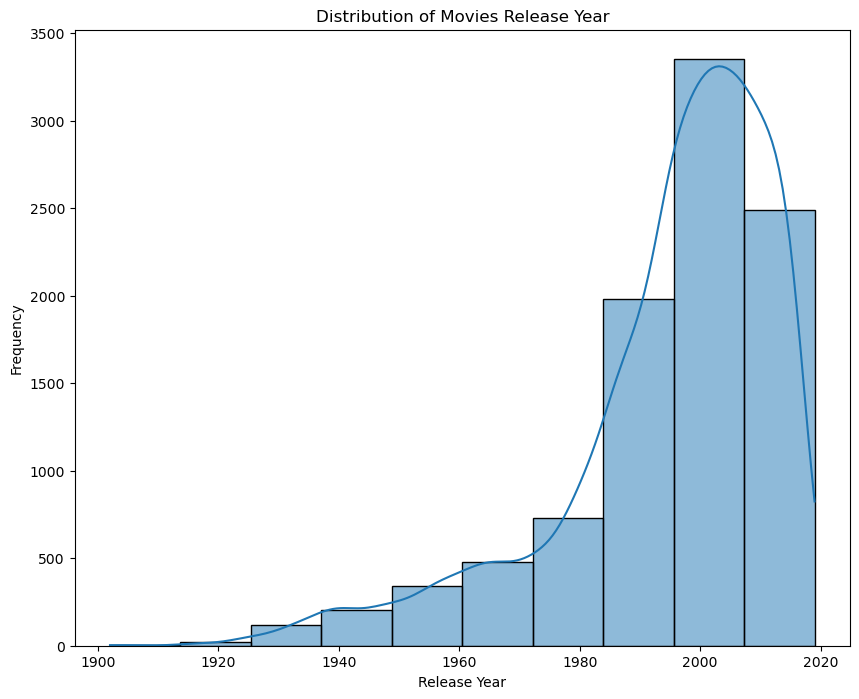

In [69]:
#distribution of the year movies were released
final_df_copy = final_df.drop_duplicates(subset="movieId")
plt.figure(figsize=(10,8))
sns.histplot(final_df_copy['year'], kde= True, bins=10) 
plt.title("Distribution of Movies Release Year")
plt.xlabel("Release Year")
plt.ylabel("Frequency")
plt.show()

**Observation**

- Most of the movies in our dataset were released after the 80s.This makes it to be negatively skewed.
- The oldest movies in our dataset were released around the 1900s.

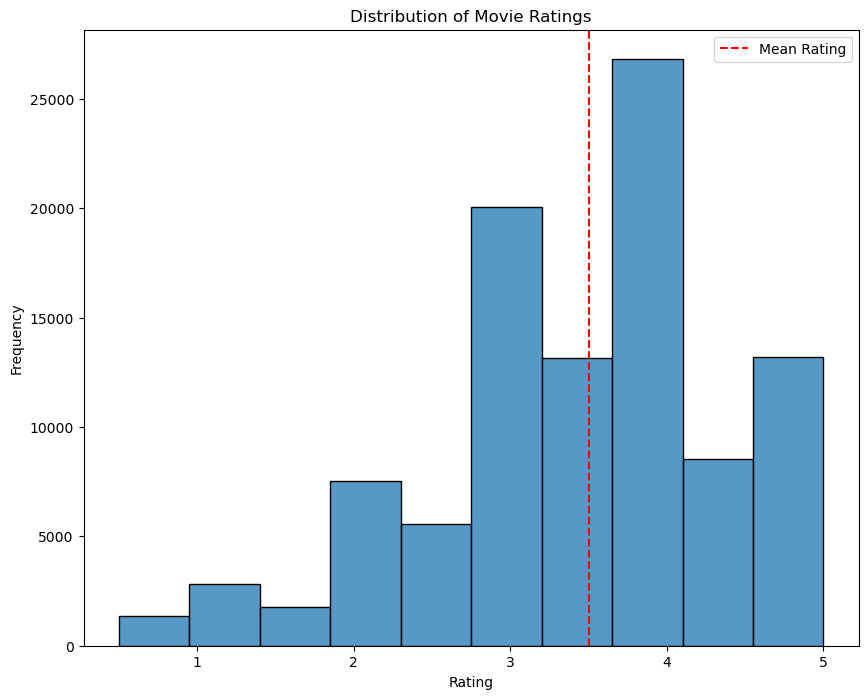

In [85]:
# distribution of ratings
plt.figure(figsize=(10,8))
sns.histplot(final_df['rating'], bins=10)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.axvline(x=final_df['rating'].mean(),color='red', linestyle='--', label= 'Mean Rating') 
plt.ylabel("Frequency")
plt.legend() 
plt.show()

**Observation**
- Over 25000 movies have been given a rating of 4.
- Less than 5000 movies have been given a rating of less than 1.5
- The mean rating of our dataset is around 3.5
   
 

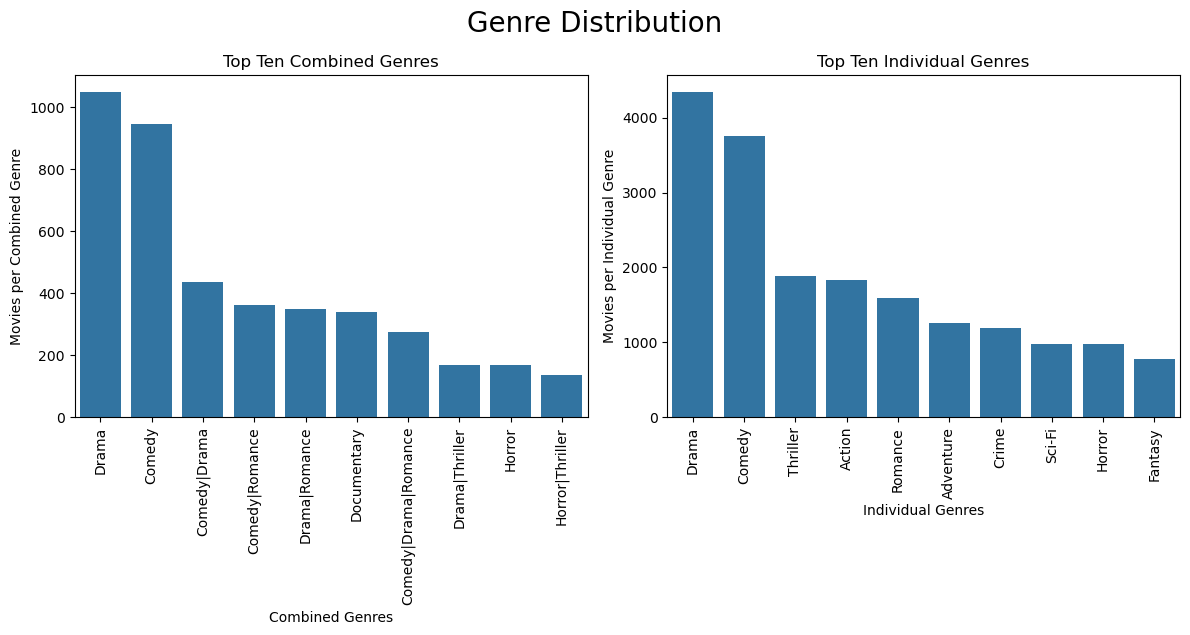

In [84]:
#making a copy of the dataset to separate the genres individually
exploded_df = final_df_copy.copy(deep=True) 
exploded_df['genres'] = exploded_df['genres'].str.split("|")
exploded_df = exploded_df.explode('genres')
exploded_df 

fig, axis= plt.subplots(ncols=2, figsize=(12,6)) 

#visualizing the combined genres
sns.countplot(data=final_df_copy, x='genres', order= final_df_copy['genres'].value_counts().head(10).index,ax=axis[0]) 
axis[0].set_title("Top Ten Combined Genres")
axis[0].set_ylabel('Movies per Combined Genre')
axis[0].set_xlabel('Combined Genres')
axis[0].tick_params(axis='x', rotation=90) 

#visualizing the individual genres
sns.barplot(data= exploded_df['genres'].value_counts().head(10),ax=axis[1])  
axis[1].set_title("Top Ten Individual Genres")
axis[1].set_ylabel('Movies per Individual Genre')
axis[1].set_xlabel('Individual Genres') 
axis[1].tick_params(axis='x', rotation=90) 

plt.tight_layout()
plt.suptitle("Genre Distribution", fontsize=20, y= 1.05)
plt.show() 


**Observation**

- Drama and comedy are the most dominant genres individually and also when combined with other genres.
- Drama is also the most present genre in the other combinations followed by comedy.
- A combination of comedy and drama genres are third highest in the combined genres plot.